# Equilibrating the 17-alanine simulation

The aim of this notebook is to create an equilibrated 17-alanine simulation. 

We will do this in the following steps:
1. Load the current 17-alanine simulation from SubtleGame.
2. Run the simulation for 1.5 ns. This should ensure that the energies and temperature are stable.
3. Save the simulation with the serialized State to an XML file.

In [1]:
from nanover.omni.openmm import OpenMMSimulation
from nanover.openmm import serializer
from openmm import app
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Storing global data

In [2]:
# 1 - input
input_xml_file = "17-ala_original.xml"

# 2 - equilibrated system
equilibrated_xml_file = "17-ala_equilibrated.xml"
equilibration_dcd_file = "17-ala_equilibration_trajectory.dcd"
equilibration_statedata_file = "17-ala_equilibration_trajectory.log"

# 3 - post equilibration MD run
final_check_dcd_path = "17-ala_equilibration_final_check.dcd"
final_check_statedata_path = "17-ala_equilibration_final_check.log"

In [3]:
# Define data labels for plotting
original_pot_energy_label = "Potential Energy (kJ/mole)"
pot_energy_label = "Potential Energy (kJ/mol)"
temp_label = "Temperature (K)"
original_step_label = '#"Step"'
sim_step_label = "Step #"
sim_step_axis_label = "Simulation time (ps)"

rolling_avg_temperature = "Rolling average temperature"
rolling_stddev_temperature = "Rolling std dev temperature"
rolling_avg_potential_energy = "Rolling average potential energy"
rolling_stddev_potential_energy = "Rolling std dev potential energy"

simulation_name= "17-alanine"

def rename_df_headings(df):
    df = df.rename(columns={'#"Step"': sim_step_label})
    df = df.rename(columns={original_pot_energy_label: pot_energy_label})
    return df

# For plotting trajectory data
def plot_data(df, y_label, rolling_avg_col, rolling_std_col, color, ylim, xlim, title, filename=None):
    plt.figure(figsize=(10, 5))
    
    # Plot raw data
    plt.plot(df[sim_step_label], df[y_label], label=y_label, color=color, alpha=0.75)
    
    # Plot rolling mean average
    plt.plot(df[sim_step_label], df[rolling_avg_col], label=f'Rolling mean avg ({window_width} ps)', color="black", linewidth=2)
    
    # Plot rolling standard deviation as a shaded region
    plt.fill_between(df[sim_step_label], 
                     df[rolling_avg_col] - df[rolling_std_col], 
                     df[rolling_avg_col] + df[rolling_std_col], 
                     color='gray', alpha=0.5, label="Rolling std dev")

    # Formatting plot
    plt.xlabel(sim_step_axis_label)
    plt.ylabel(y_label)
    plt.ylim(ylim)
    plt.xlim(xlim)

    # Dynamically set x-ticks based on xlim, excluding non-whole step limits
    step_size = 300
    max_tick = (xlim[1] // step_size) * step_size  # Ensure the last tick is aligned with step size
    plt.xticks(range(int(xlim[0]), max_tick + step_size, step_size))
    plt.minorticks_on()

    plt.title(title)
    plt.legend(loc='center right')

    # Show or save
    if filename:
        plt.savefig(filename)
    plt.show()

## Step 2: Equilibration

In [ ]:
# Create server
simulation = OpenMMSimulation.from_xml_path(input_xml_file)
simulation.load()

# Create reporters for recording the simulation
dcd_reporter = app.DCDReporter(equilibration_dcd_file, 1)
statedata_reporter = app.StateDataReporter(equilibration_statedata_file, 1, 
                                           temperature=True, step=True,
                                           time=True, potentialEnergy=True, kineticEnergy=True)

# Attach reporters
simulation.simulation.reporters.append(dcd_reporter)
simulation.simulation.reporters.append(statedata_reporter)

In [ ]:
# Perform energy minimisation
simulation.simulation.minimizeEnergy()

In [ ]:
# Set parameters
total_time_in_ps = 1500
time_step_interval = 0.002 # in ps
desired_interval_in_ps = 100

total_num_steps = total_time_in_ps/time_step_interval
print(f"Running for {total_num_steps} steps")

# Run the dynamics
cumulative_total_time_ps = 0

for n in range(int(total_time_in_ps/desired_interval_in_ps)):
    
    simulation.simulation.step(desired_interval_in_ps)
    cumulative_total_time_ps += desired_interval_in_ps
    print(f"{cumulative_total_time_ps} ps run.")

    # Save the simulation with the serialized State
    file_name =  f"17-ala_equilibration_run_{cumulative_total_time_ps}_ps.xml"
    with open(file_name, 'w') as outfile:
        outfile.write(serializer.serialize_simulation(simulation.simulation, save_state=True))

with open(equilibrated_xml_file, 'w') as outfile:
        outfile.write(serializer.serialize_simulation(simulation.simulation, save_state=True))

In [ ]:
# Close the reporters
dcd_reporter.__del__()
statedata_reporter.__del__()

## Step 2.5: Analysis

Read the data saved by the StateDataReporter to plot the temperature and potential energy.

In [33]:
# Load trajectory data
df = pd.read_csv(equilibration_statedata_file, sep=",")
df = rename_df_headings(df)

# Compute rolling averages
window_width = 100
rolling_metrics = {
    temp_label: (rolling_avg_temperature, rolling_stddev_temperature),
    pot_energy_label: (rolling_avg_potential_energy, rolling_stddev_potential_energy)
}

for column, (avg_col, std_col) in rolling_metrics.items():
    df[avg_col] = df[column].rolling(window=window_width, min_periods=window_width).mean()
    df[std_col] = 2 * df[column].rolling(window=window_width, min_periods=window_width).std() # 2 sigma

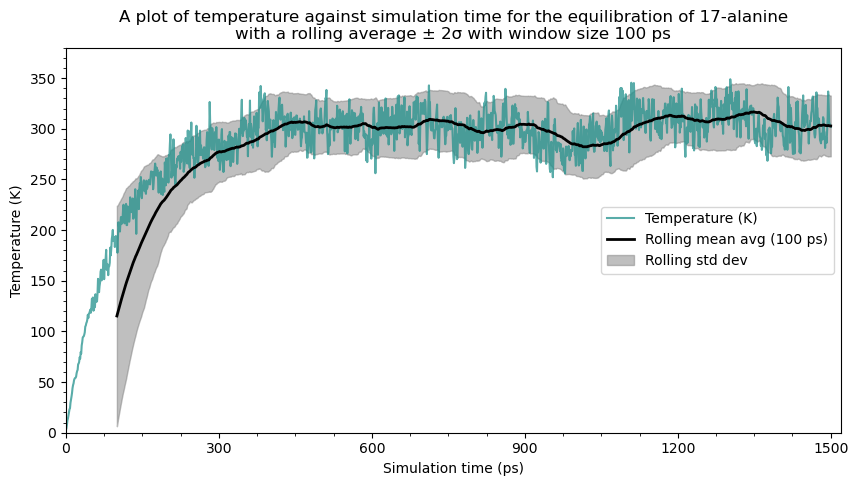

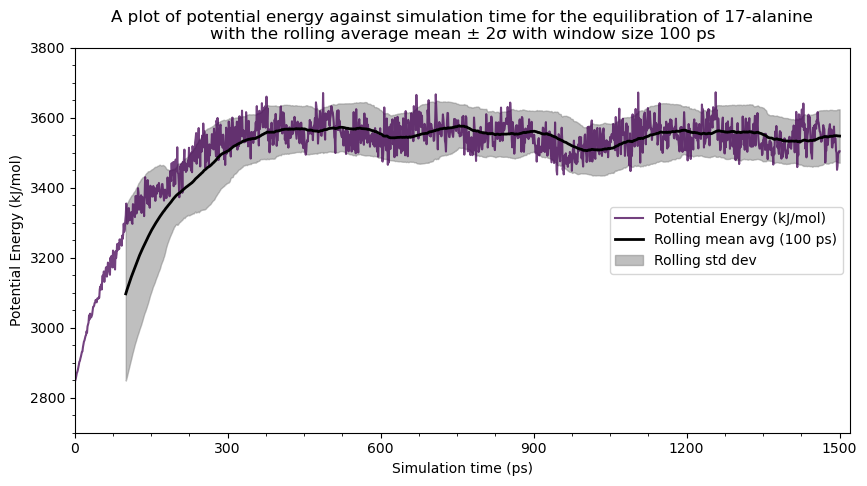

In [34]:
# Plot Temperature
title = f'A plot of temperature against simulation time for the equilibration of {simulation_name}\nwith a rolling average \u00B1 2\u03C3 with window size {window_width} ps'

filename = f'{simulation_name}_equilibration_temperature-against-time.png'
plot_data(df, temp_label, rolling_avg_temperature, rolling_stddev_temperature, 
          "#21918c", (0, 380), (0, 1520), 
          title, filename=filename)

# Plot Potential Energy
filename = f'{simulation_name}_equilibration_potential-energy-against-time.png'
title = f'A plot of potential energy against simulation time for the equilibration of {simulation_name}\nwith the rolling average mean \u00B1 2\u03C3 with window size {window_width} ps'

plot_data(df, pot_energy_label, rolling_avg_potential_energy, rolling_stddev_potential_energy, 
          "#440154", (2700, 3800), (0, 1520), 
          title, filename=filename)


## Step 3: Post-equilibration run for final check of equilibration

In [ ]:
# Create OpenMM simulation
simulation = OpenMMSimulation.from_xml_path(equilibrated_xml_file)
simulation.load()

# Create reporters for recording the simulation
dcd_reporter = app.DCDReporter(final_check_dcd_path, 1)
statedata_reporter = app.StateDataReporter(final_check_statedata_path, 1, 
                                           temperature=True, step=True,
                                           time=True, potentialEnergy=True, kineticEnergy=True)

# Attach reporters
simulation.simulation.reporters.append(dcd_reporter)
simulation.simulation.reporters.append(statedata_reporter)

In [ ]:
# Set parameters
total_time_in_ps = 1500
time_step_interval = 0.002 # in ps
desired_interval_in_ps = 100

total_num_steps = total_time_in_ps/time_step_interval
print(f"Running for {total_num_steps} steps")

# Run the dynamics
cumulative_total_time_ps = 0

for n in range(int(total_time_in_ps/desired_interval_in_ps)):
    
    simulation.simulation.step(desired_interval_in_ps)
    cumulative_total_time_ps += desired_interval_in_ps
    print(f"{cumulative_total_time_ps} ps run.")

    # Save the simulation with the serialized State
    file_name =  f"17-ala_equilibration_final_check_{cumulative_total_time_ps}_ps.xml"
    with open(file_name, 'w') as outfile:
        outfile.write(serializer.serialize_simulation(simulation.simulation, save_state=True))


In [ ]:
# Close the reporters
dcd_reporter.__del__()
statedata_reporter.__del__()

## Step 3.5: Analysis

In [36]:
# Load the log file into a Pandas DataFrame
df_final_check = pd.read_csv(final_check_statedata_path, sep=",")
df_final_check = rename_df_headings(df_final_check)

# Compute rolling averages
window_width = 100
rolling_metrics = {
    temp_label: (rolling_avg_temperature, rolling_stddev_temperature),
    pot_energy_label: (rolling_avg_potential_energy, rolling_stddev_potential_energy)
}

for column, (avg_col, std_col) in rolling_metrics.items():
    df_final_check[avg_col] = df_final_check[column].rolling(window=window_width, min_periods=1).mean()
    df_final_check[std_col] = 2 * df_final_check[column].rolling(window=window_width, min_periods=1).std() # 2 sigma

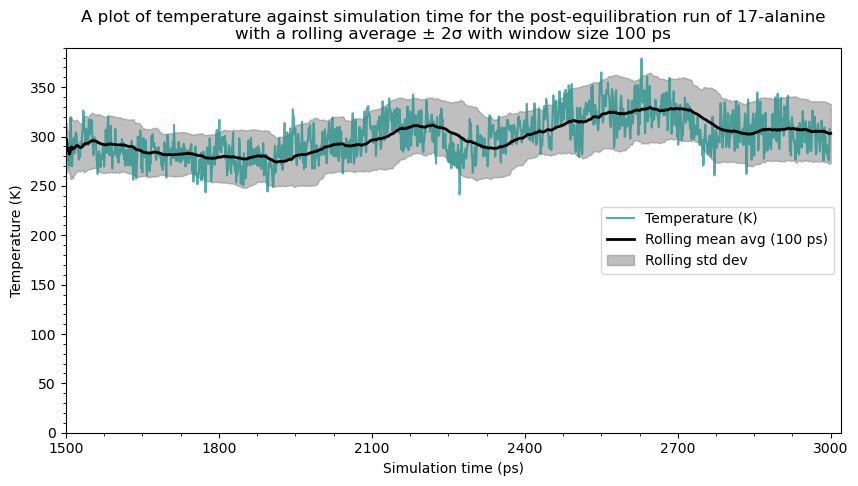

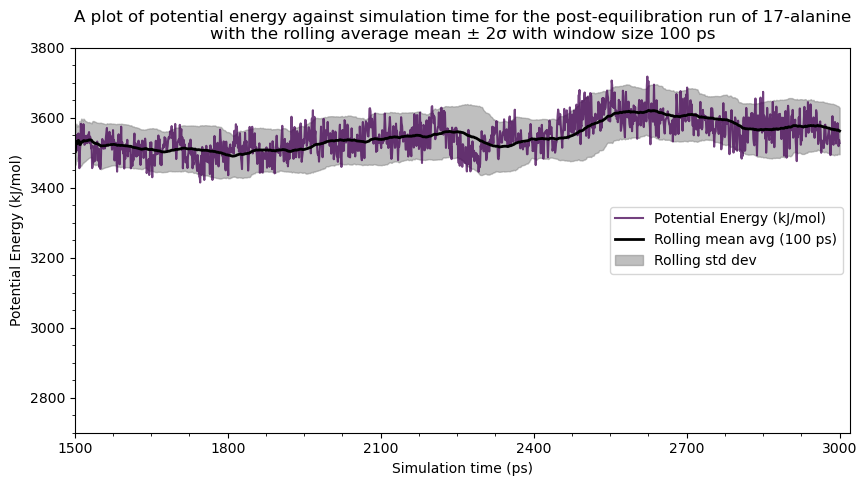

In [37]:
# Plot Temperature
title = f'A plot of temperature against simulation time for the post-equilibration run of {simulation_name}\nwith a rolling average \u00B1 2\u03C3 with window size {window_width} ps'

filename = f'{simulation_name}_post-equilibration-run_temperature-against-time.png'
plot_data(df_final_check, temp_label, rolling_avg_temperature, rolling_stddev_temperature, 
          "#21918c", (0, 390), (1500, 3020), 
          title, filename=filename)

# Plot Potential Energy
filename = f'{simulation_name}_post-equilibration-run_potential-energy-against-time.png'
title = f'A plot of potential energy against simulation time for the post-equilibration run of {simulation_name}\nwith the rolling average mean \u00B1 2\u03C3 with window size {window_width} ps'

plot_data(df_final_check, pot_energy_label, rolling_avg_potential_energy, rolling_stddev_potential_energy, 
          "#440154", (2700, 3800), (1500, 3020), 
          title, filename=filename)